# Milestone Project 01: Food Sight


# Check GPU

* Google colab offers Tesla T4 which supports mixed precision, taht can be used to speed up the model training process

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8543874f-d06b-9103-be9a-bac82b295e85)


#Get Helper Functions
* Created a python file with helper functions that will be used recursively in this notebook

In [ ]:
!wget "https://raw.githubusercontent.com/HemachandranD/foodsight/main/notebook/helper_functions.py"

--2022-07-13 07:11:44--  https://raw.githubusercontent.com/HemachandranD/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-13 07:11:45 (83.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
#Import helper fucntions
from helper_functions import unzip_data, \
walk_through_dir, \
create_tensorboard_callback, \
plot_loss_curves, \
compare_historys

# Using Tensorflow Datasets to get the Food vision Data using TFDS
* [Food Vision Data Catalogue](https://www.tensorflow.org/datasets/catalog/food101)


In [ ]:
#Import Tensorflow datasets
import tensorflow_datasets as tfds

In [ ]:
#List all the avaialble datasets
datasets_lists = tfds.list_builders()
print('food101' in datasets_lists)

True


In [ ]:
#load in the data 
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True,#data gets returned in tuple (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteNS8FY0/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteNS8FY0/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


# Exploring the Food101 dataset using TFDS
* class name
* shape of input data
* datatype of input data
* labels

In [ ]:
#Features of food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
#get class_names
class_names= ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
#Take one sample of data
sample_one_data= test_data.take(1)
sample_one_data

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


  Image Shape: (382, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class: 29
  Class Name: cup_cakes
  


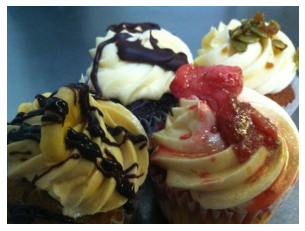

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for image, label in sample_one_data:
  print(f"""
  Image Shape: {image.shape}
  Image datatype: {image.dtype}
  Target class: {label}
  Class Name: {class_names[label.numpy()]}
  """)
  plt.imshow(image)
  plt.axis(False);

In [ ]:
#Find min and max values
import tensorflow as tf
tf.reduce_min(image).numpy(), tf.reduce_max(image).numpy()

(0, 255)

# Our preprcessing function must perform below actions
* Reshape the image
* convert the dtypr unit8 to float32

In [ ]:
def preprocess_img(image, label, img_shape=224):
  """
  converts the image datatype 'unit8' to 'float32'
  image to [imag_shape, img_shape, colour_channels]
  """
  image= tf.image.resize(image, [img_shape, img_shape])
  # image= image/255. (not required for efficientnet network)
  return tf.cast(image, tf.float32), label

In [ ]:
#preprocess a sample image and check teh outputs
preprocessed_img = preprocess_img(image, label)[0]
preprocessed_img
print(f"Image before preprocessing:\n {image[:2]}....,, \nShape: {image.shape},\nDataType: {image.dtype}\n ")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}....,, \nShape: {preprocessed_img.shape},\nDataType: {preprocessed_img.dtype}\n ")

Image before preprocessing:
 [[[ 34  76 100]
  [ 30  72  96]
  [ 29  70  92]
  ...
  [ 81 101 108]
  [ 77  97 104]
  [ 69  89  96]]

 [[ 35  77 101]
  [ 32  74  98]
  [ 32  73  95]
  ...
  [ 75  95 102]
  [ 72  92  99]
  [ 68  88  95]]]....,, 
Shape: (382, 512, 3),
DataType: <dtype: 'uint8'>
 
Image after preprocessing:
 [[[ 32.007973  74.00797   98.00797 ]
  [ 32.516262  73.516266  95.516266]
  [ 36.433033  72.14317   95.94132 ]
  ...
  [ 73.05832   93.05832  103.04107 ]
  [ 75.82466   95.82466  103.47962 ]
  [ 72.883064  92.883064  99.883064]]

 [[ 34.751595  76.751595 100.77232 ]
  [ 36.919323  76.91933  101.91933 ]
  [ 34.583862  70.15529   94.48565 ]
  ...
  [ 74.312454  94.25442  105.42853 ]
  [ 67.94196   87.94196   97.04974 ]
  [ 67.66355   87.66355   94.73817 ]]]....,, 
Shape: (224, 224, 3),
DataType: <dtype: 'float32'>
 


# Batch & Prepare the datasets

We're now going to make a data input pipleine which runs really fast

For more please visit: Tensorflow data performance documenattion

In [ ]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
#Map preprocessing function to training and parallelize
train_data= train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
#shuffle train_data and prefetch
train_data= train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

#Map testing data
test_data= test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
#Already import create tensorboard function

#create modelcheckpoint path
checkpoint_path= 'model_checkpoints/cp.ckpt'
model_checkpoint= tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                     monitor='val_accuracy',
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=0)

In [ ]:
tf.__version__

'2.8.2'

#setup mixed precision training

For more, refre the tensorflow guide of mixed precision

Mixed precision utilizes the combination of float32 and float16 datatype to speed up performance

In [ ]:
# #import mixed precision
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

#Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create base model
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#Create Functional model
inputs = tf.keras.Input(shape=input_shape, name='input_layer')
# x=preprocessing.Rescaling(1/255.) not required as we use efficientnet model
x=base_model(inputs, training=False)
x= tf.keras.layers.GlobalAveragePooling2D()(x)
x= layers.Dense(len(class_names))(x)
outputs=layers.Activation('softmax', name='softmax')(x)

model=tf.keras.Model(inputs, outputs)

#Compile the Model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax (Activation)        (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [ ]:
model.layers[1]

In [ ]:
#check dtype policy of layers
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pooling2d True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax True float32 <Policy "float32">


In [ ]:
#check dtype policy of base_model layers
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">
block2a_expand_activation False float32 <Policy "float32">


#Fit the feature Extraction model
1. Build a feature extraction model(train a couple output layers with base layers frozen)
2. Fine tune some of the frozen layers

In [ ]:
#Fit a feature extraction model with call_backs
history_101_food_classes_feature_extract= model.fit(train_data,
                                                    epochs=3,
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15 * len(test_data)),
                                                    callbacks=[create_tensorboard_callback(dir_name='training_logs',
                                                                                           experiment_name='efficientnetb0_101_food_classes_all_data_feature_extract'),
                                                               model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_food_classes_all_data_feature_extract/20220713-040751
Epoch 1/3
2368/2368 [==============================] - 201s 77ms/step - loss: 1.8250 - accuracy: 0.5568 - val_loss: 1.2320 - val_accuracy: 0.6782
Epoch 2/3
2368/2368 [==============================] - 181s 75ms/step - loss: 1.2947 - accuracy: 0.6655 - val_loss: 1.1304 - val_accuracy: 0.6984
Epoch 3/3
2368/2368 [==============================] - 178s 75ms/step - loss: 1.1451 - accuracy: 0.7016 - val_loss: 1.0957 - val_accuracy: 0.7055


In [ ]:
#Evaluate on all test_data
results_feature_extract_model=model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 54s 68ms/step - loss: 1.0956 - accuracy: 0.7039


[1.0956215858459473, 0.7039207816123962]

Load and evaluate checkpoint weights

In [ ]:
#clone the model we created (cloning copies the model with resetted wights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax (Activation)        (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [ ]:
!ls model_checkpoints/

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [ ]:
checkpoint_path

'model_checkpoints/cp.ckpt'

In [ ]:
cloned_model.load_weights(checkpoint_path)

In [ ]:
#Compile the m odel as the weights are loaded
cloned_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

#Evaluate the cloned model with loaded weights
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 54s 64ms/step - loss: 1.7188 - accuracy: 0.5486


In [ ]:
#loaded checkpoint weights should return similar weights to checkpoints weights
import numpy as np
np.isclose(results_feature_extract_model ,results_cloned_model_with_loaded_weights)

array([False, False])

In [ ]:
#check dtype policy of base_model layers
for layer in cloned_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">
block2a_expand_activation False float32 <Policy "float32">


Save the whole model to a file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

AttributeError: ignored

In [ ]:
#save the model to gdrive
import os

savedir='/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extracted_101_classes_non_mixed_precision/'
model.save(savedir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extracted_101_classes_non_mixed_precision/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extracted_101_classes_non_mixed_precision/assets


In [ ]:
#save to local
save_dir="07_efficientnetb0_feature_extraction_non_mixed_precision"
model.save(save_dir)

INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extraction_non_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extraction_non_mixed_precision/assets


In [ ]:
#load saved_model from gdrive
savedir='/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extracted_101_classes_non_mixed_precision/'
load_saved_model = tf.keras.models.load_model(savedir)

In [ ]:
#check loaded model dtype policy
for layer in load_saved_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">
block2a_expand_activation False float32 <Policy "float32">


In [ ]:
#evaluate the loaded_model
results_loaded_saved_model = load_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 67s 69ms/step - loss: 1.0956 - accuracy: 0.7039


[1.0956215858459473, 0.7039207816123962]

In [ ]:
results_loaded_saved_model

[1.0956215858459473, 0.7039207816123962]

In [ ]:
#loaded checkpoint weights should return similar weights to checkpoints weights
import numpy as np
np.isclose(results_feature_extract_model ,results_loaded_saved_model).all()

NameError: ignored

#Preparing the model for fine tuning

In [ ]:
load_saved_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax (Activation)        (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [ ]:
#let's unfreeze the top few layers and froze others

for layer in load_saved_model.layers:
  layer.trainable=True
  print(layer, layer.trainable, layer.dtype, layer.dtype_policy)

<keras.engine.input_layer.InputLayer object at 0x7f1ef6873f90> True float32 <Policy "float32">
<keras.engine.functional.Functional object at 0x7f1ef27e8fd0> True float32 <Policy "float32">
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f1ef68d3750> True float32 <Policy "float32">
<keras.layers.core.dense.Dense object at 0x7f1ef68bf090> True float32 <Policy "float32">
<keras.layers.core.activation.Activation object at 0x7f1ef68bfb90> True float32 <Policy "float32">


In [ ]:
#basemodel layer

for layer in load_saved_model.layers[1].layers[-1:]:
  print(layer, layer.trainable, layer.dtype, layer.dtype_policy)

<keras.layers.core.activation.Activation object at 0x7f1ef81580d0> True float32 <Policy "float32">


In [ ]:
#setup early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

#create checkpoint to save model
checkpoint_path='finetune_checkpoints/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_loss',
                                                      save_best_only=True)

In [ ]:
#creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [ ]:
#compile the model
load_saved_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer = tf.keras.optimizers.Adam(0.001),
                         metrics=['accuracy'])

In [ ]:
#start fitting
history_101_food_classes_all_data_fine_tune = load_saved_model.fit(train_data,
                                                                   epochs=5,
                                                                   steps_per_epoch=len(train_data),
                                                                   validation_data=test_data,
                                                                   validation_steps=int(0.15* len(test_data)),
                                                                   callbacks=[create_tensorboard_callback(dir_name='training_logs',
                                                                              experiment_name='efficientnetb0_101_food_classes_all_data_fine_tune'),
                                                                              model_checkpoint,
                                                                              early_stopping, 
                                                                              reduce_lr])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_food_classes_all_data_fine_tune/20220713-073501
Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.6078 - accuracy: 0.5862INFO:tensorflow:Assets written to: finetune_checkpoints/assets


INFO:tensorflow:Assets written to: finetune_checkpoints/assets


2368/2368 [==============================] - 880s 365ms/step - loss: 1.6078 - accuracy: 0.5862 - val_loss: 1.2003 - val_accuracy: 0.6790 - lr: 0.0010
Epoch 2/5
2368/2368 [==============================] - ETA: 0s - loss: 1.2227 - accuracy: 0.6752INFO:tensorflow:Assets written to: finetune_checkpoints/assets


INFO:tensorflow:Assets written to: finetune_checkpoints/assets


2368/2368 [==============================] - 869s 366ms/step - loss: 1.2227 - accuracy: 0.6752 - val_loss: 1.0621 - val_accuracy: 0.7097 - lr: 0.0010
Epoch 3/5
2368/2368 [==============================] - 839s 353ms/step - loss: 1.0037 - accuracy: 0.7283 - val_loss: 1.1118 - val_accuracy: 0.7026 - lr: 0.0010
Epoch 4/5
2368/2368 [==============================] - ETA: 0s - loss: 0.8721 - accuracy: 0.7594
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [==============================] - 844s 355ms/step - loss: 0.8721 - accuracy: 0.7594 - val_loss: 1.0772 - val_accuracy: 0.7164 - lr: 0.0010
Epoch 5/5
2368/2368 [==============================] - ETA: 0s - loss: 0.3309 - accuracy: 0.9049INFO:tensorflow:Assets written to: finetune_checkpoints/assets


INFO:tensorflow:Assets written to: finetune_checkpoints/assets


2368/2368 [==============================] - 864s 364ms/step - loss: 0.3309 - accuracy: 0.9049 - val_loss: 0.7974 - val_accuracy: 0.8117 - lr: 2.0000e-04


In [ ]:
#save fine tuned model to google drive
load_saved_model.save('/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision/assets


In [ ]:
#save fine tuned model to local 
load_saved_model.save('food_vision/07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision/')

INFO:tensorflow:Assets written to: food_vision/07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision/assets


INFO:tensorflow:Assets written to: food_vision/07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision/assets


In [ ]:
#evaluate mixed precision trained loaded model
results_loaded_gs_model_fine_tuned= load_saved_model.evaluate(test_data)
results_loaded_gs_model_fine_tuned

790/790 [==============================] - 57s 71ms/step - loss: 0.7794 - accuracy: 0.8126


[0.7793891429901123, 0.8126336336135864]

#Download fine tuned model from google storage

In [ ]:
# #download and evaluate the fine tuned model from google drive
# Download and evaluate fine-tuned model from Google Storage
#!wget <<>>
#copy from gdive after mounting
!cp /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision.zip /content/

In [ ]:
# # Unzip fine-tuned model
!mkdir downloaded_fine_tuned_gs_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip 07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision -d downloaded_fine_tuned_gs_model

Archive:  07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision.zip
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision/assets/
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision/keras_metadata.pb  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision/saved_model.pb  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision/variables/variables.index  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision/variables/variables.data-00000-of-00001  


In [ ]:
import tensorflow as tf
# # Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_gs_model = tf.keras.models.load_model("downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_non_mixed_precision")

In [ ]:
loaded_fine_tuned_gs_model.save('my_food_sight_model.h5')

In [ ]:
# loaded_fine_tuned_gs_model = tf.keras.models.load_model('food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/')

In [ ]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

In [ ]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 60s 72ms/step - loss: 0.7794 - accuracy: 0.8126


[0.7793891429901123, 0.8126336336135864]

#View Results on Tensorborad

In [ ]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/compat/__init__.py", line 42, in tf
    from tensorboard.compat import notf  # noqa: F401
ImportError: cannot import name 'notf' from 'tensorboard.compat' (/usr/local/lib/python3.7/dist-packages/tensorboard/compat/__init__.py)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 39, in run_main
    main_lib.global_init()
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main_lib.py", line 40, in global_init
    if getattr(tf, "__version__", "stub") == "stub":
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/lazy.py", line 65, in __getattr__
    return getattr(load_once(self), attr_name)
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/lazy.py", line 97, in wrap

#Evaluate your trained model
Some ideas you might want to go through:

1.Find the precision, recall and f1 scores for each class (all 101).
2. Build a confusion matrix for each of the classes.
3. Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction).

In [ ]:
#Prediction probabilities
pred_probs = loaded_fine_tuned_gs_model.predict(test_data)
pred_probs.shape

(25250, 101)

In [ ]:
pred_probs

array([[1.4839282e-12, 9.3534315e-17, 8.8742890e-16, ..., 4.7159147e-12,
        7.6985190e-13, 7.8527032e-11],
       [2.4463789e-20, 4.2575730e-24, 6.2564584e-23, ..., 3.4447579e-17,
        7.6104623e-19, 1.3981076e-26],
       [1.3933721e-15, 9.7419584e-19, 1.5788974e-15, ..., 3.3095488e-16,
        2.8470177e-17, 1.0237083e-13],
       ...,
       [3.6088237e-05, 7.0065633e-09, 4.5496826e-10, ..., 1.3469094e-13,
        5.1554655e-10, 2.5590394e-05],
       [7.0657019e-25, 0.0000000e+00, 0.0000000e+00, ..., 2.0482456e-38,
        2.9801796e-38, 1.1149424e-30],
       [5.1708605e-13, 2.6834417e-24, 1.2179017e-17, ..., 1.4956704e-08,
        2.7686231e-24, 1.8863232e-17]], dtype=float32)

In [ ]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [1.48392821e-12 9.35343146e-17 8.87428901e-16 3.47522133e-16
 6.75523569e-12 1.19236988e-12 2.86123668e-23 2.65336421e-18
 2.76071043e-14 1.82088600e-15 4.41160238e-14 1.08273823e-17
 4.01681015e-14 3.26466880e-16 1.03005044e-11 2.79241908e-16
 2.82786711e-10 6.58489214e-13 5.68168972e-20 9.06565665e-17
 2.63114420e-22 1.52231595e-11 1.86237479e-08 2.85263557e-17
 3.17376589e-22 1.67697783e-17 3.89909052e-17 7.34597821e-13
 2.88540011e-19 9.99999881e-01 1.73227843e-09 1.52690576e-17
 8.01246626e-20 4.76438665e-22 1.07044360e-15 1.09517434e-19
 7.06034056e-17 4.55849872e-17 6.10839175e-19 1.08273823e-17
 2.65736134e-21 1.71572143e-21 2.95114389e-12 7.92148273e-18
 4.51352507e-18 1.09188219e-13 1.11879094e-20 8.43237512e-18
 1.05988273e-16 2.70650532e-16 2.26954289e-18 1.17742336e-18
 3.82253396e-19 7.67776471e-18 1.75536022e-25 1.42408288e-13
 3.89322601e-14 6.77560349e-18 4.99900075e-

In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([29, 81, 91, 53, 97, 97, 10, 31,  3,  8])

In [ ]:
pred_classes

array([29, 81, 91, ..., 46, 31, 21])

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
len(y_labels), len(pred_classes)

(25250, 25250)

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.808950495049505

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
class_report = classification_report(y_labels, pred_classes)
print(class_report)

              precision    recall  f1-score   support

           0       0.58      0.57      0.58       250
           1       0.85      0.74      0.79       250
           2       0.87      0.89      0.88       250
           3       0.84      0.88      0.86       250
           4       0.75      0.80      0.78       250
           5       0.74      0.74      0.74       250
           6       0.79      0.86      0.83       250
           7       0.93      0.91      0.92       250
           8       0.63      0.61      0.62       250
           9       0.72      0.69      0.70       250
          10       0.79      0.69      0.74       250
          11       0.83      0.87      0.85       250
          12       0.89      0.85      0.87       250
          13       0.82      0.84      0.83       250
          14       0.78      0.84      0.81       250
          15       0.73      0.68      0.70       250
          16       0.70      0.72      0.71       250
          17       0.88    

In [ ]:
class_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

In [ ]:
class_report_dict

{'0': {'f1-score': 0.5754527162977867,
  'precision': 0.5789473684210527,
  'recall': 0.572,
  'support': 250},
 '1': {'f1-score': 0.7914893617021277,
  'precision': 0.8454545454545455,
  'recall': 0.744,
  'support': 250},
 '10': {'f1-score': 0.7393162393162394,
  'precision': 0.7935779816513762,
  'recall': 0.692,
  'support': 250},
 '100': {'f1-score': 0.8526522593320235,
  'precision': 0.8378378378378378,
  'recall': 0.868,
  'support': 250},
 '11': {'f1-score': 0.8509803921568627,
  'precision': 0.8346153846153846,
  'recall': 0.868,
  'support': 250},
 '12': {'f1-score': 0.8706365503080081,
  'precision': 0.8945147679324894,
  'recall': 0.848,
  'support': 250},
 '13': {'f1-score': 0.8284023668639053,
  'precision': 0.8171206225680934,
  'recall': 0.84,
  'support': 250},
 '14': {'f1-score': 0.8053949903660886,
  'precision': 0.7769516728624535,
  'recall': 0.836,
  'support': 250},
 '15': {'f1-score': 0.7041666666666666,
  'precision': 0.7347826086956522,
  'recall': 0.676,
  's

In [ ]:
# Create empty dictionary
class_f1_scores = {}
class_recall = {}
class_precision = {}

for k, v in class_report_dict.items():
  if k == 'accuracy':
    break;
  else:
    class_f1_scores[class_names[int(k)]] =v["f1-score"]
    class_recall[class_names[int(k)]] =v["recall"]
    class_precision[class_names[int(k)]] =v["precision"]

In [ ]:
class_names=['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich',
 'macaroni_and_cheese',
 'macarons',
 'miso_soup',
 'mussels',
 'nachos',
 'omelette',
 'onion_rings',
 'oysters',
 'pad_thai',
 'paella',
 'pancakes',
 'panna_cotta',
 'peking_duck',
 'pho',
 'pizza',
 'pork_chop',
 'poutine',
 'prime_rib',
 'pulled_pork_sandwich',
 'ramen',
 'ravioli',
 'red_velvet_cake',
 'risotto',
 'samosa',
 'sashimi',
 'scallops',
 'seaweed_salad',
 'shrimp_and_grits',
 'spaghetti_bolognese',
 'spaghetti_carbonara',
 'spring_rolls',
 'steak',
 'strawberry_shortcake',
 'sushi',
 'tacos',
 'takoyaki',
 'tiramisu',
 'tuna_tartare',
 'waffles']

In [ ]:
import pandas as pd

f1_score_df= pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1_score": list(class_f1_scores.values())}).sort_values("f1_score", ascending=False)

recall_df= pd.DataFrame({"class_name": list(class_recall.keys()),
                          "recall": list(class_recall.values())}).sort_values("recall", ascending=False)

precision_df= pd.DataFrame({"class_name": list(class_precision.keys()),
                          "precision": list(class_precision.values())}).sort_values("precision", ascending=False)

In [ ]:
f1_score_df

,class_name,f1_score
33,edamame,0.987952
63,macarons,0.955645
75,pho,0.925852
54,hot_and_sour_soup,0.924000
7,bibimbap,0.923077
...,...,...
22,chocolate_mousse,0.615063
39,foie_gras,0.602972
0,apple_pie,0.575453
77,pork_chop,0.573643


In [ ]:
# 2Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,29,29,1.000000,cup_cakes,cup_cakes
1,81,81,0.999157,ramen,ramen
2,91,91,0.999982,spaghetti_carbonara,spaghetti_carbonara
3,53,53,0.999944,hamburger,hamburger
4,97,97,0.999967,takoyaki,takoyaki


In [ ]:
pred_df["pred_correct"]= pred_df['y_true'] == pred_df['y_pred']
pred_df

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,29,29,1.000000,cup_cakes,cup_cakes,True
1,81,81,0.999157,ramen,ramen,True
2,91,91,0.999982,spaghetti_carbonara,spaghetti_carbonara,True
3,53,53,0.999944,hamburger,hamburger,True
4,97,97,0.999967,takoyaki,takoyaki,True
...,...,...,...,...,...,...
25245,38,38,1.000000,fish_and_chips,fish_and_chips,True
25246,86,86,0.999990,sashimi,sashimi,True
25247,76,46,0.936617,pizza,garlic_bread,False
25248,31,31,1.000000,donuts,donuts,True


In [ ]:
#top 100 wrong predictions
top_wrong=pred_df[pred_df['pred_correct']== False].sort_values('pred_conf', ascending=False)[:100]
top_wrong

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
17351,92,85,1.000000,spring_rolls,samosa,False
7853,71,87,1.000000,paella,scallops,False
14723,58,100,1.000000,ice_cream,waffles,False
1113,72,67,1.000000,pancakes,omelette,False
2213,16,98,1.000000,cheesecake,tiramisu,False
...,...,...,...,...,...,...
23327,73,94,0.999993,panna_cotta,strawberry_shortcake,False
6603,86,95,0.999992,sashimi,sushi,False
10483,92,40,0.999992,spring_rolls,french_fries,False
2226,86,95,0.999992,sashimi,sushi,False


In [ ]:
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax-float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

#Predict custom images

# New section

In [ ]:
class_names

NameError: ignored

In [ ]:
def load_and_prep_image(filename, true_label, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  img=tf.io.read_file(filename)

  img=tf.io.decode_image(img)

  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    img=tf.cast(img, tf.float32)
    pred_prob = loaded_fine_tuned_gs_model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]
    if true_label == pred_class: # Change the color of text based on whether prediction is right or wrong
      title_color = "g"
    else:
      title_color = "r"
    plt.imshow(img/255.)
    plt.title(f"actual: {true_label}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False)
  

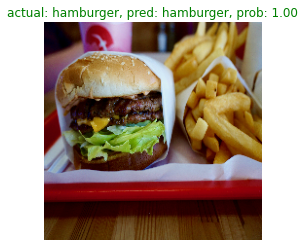

In [ ]:
load_and_prep_image('/content/custom_food_images/hamburger.jpeg','hamburger', scale=False)

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2022-07-13 06:01:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  17.1MB/s    in 0.7s    

2022-07-13 06:01:15 (17.1 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
tf.__version__

'2.8.2'